In [1]:
# Double Q-learning, SARSA(λ), Q(λ), Dyna-Q

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def probability_success(env, pi, goal_state, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, _, done, _ = env.step(pi(state))
        results.append(state == goal_state)
    return np.sum(results)/len(results)

In [9]:
def mean_return(env, pi, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward
    return np.mean(results)

In [10]:
def regret_accumulation(env, pi, optimal_Q, iterations=10):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            state, reward, done, _ = env.step(action)
            results[-1] += regret
    return np.mean(results)

In [11]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [12]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
def plot_value_function(title, V_track, V_true=None, log=False):
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        if not (V_true is None) and V_true[i] < 0.1:
            continue
        line_type = next(linecycler)
        label = 'Estimated V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if not (V_true is None):
            label = 'True v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1.1+loc*0.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

In [14]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

In [15]:
env = gym.make('SlipperyWalkSeven-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, 0.99)
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=8)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤════════╤════════╕
│   s │      < │      > │
╞═════╪════════╪════════╡
│   0 │ 0      │ 0      │
├─────┼────────┼────────┤
│   1 │ 0.3119 │ 0.5637 │
├─────┼────────┼────────┤
│   2 │ 0.6703 │ 0.763  │
├─────┼────────┼────────┤
│   3 │ 0.8032 │ 0.8449 │
├─────┼────────┼────────┤
│   4 │ 0.8638 │ 0.8892 │
├─────┼────────┼────────┤
│   5 │ 0.9014 │ 0.922  │
├─────┼────────┼────────┤
│   6 │ 0.9322 │ 0.9515 │
├─────┼────────┼────────┤
│   7 │ 0.9613 │ 0.9806 │
├─────┼────────┼────────┤
│   8 │ 0      │ 0      │
╘═════╧════════╧════════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 97.90%. Obtains an average undiscounted return of 0.9790.


# Double Q-Learning

In [16]:
def double_q_learning(env,
                      gamma=1.0,
                      init_alpha=0.5,
                      min_alpha=0.01,
                      alpha_decay_ratio=0.3,
                      init_epsilon=1.0,
                      min_epsilon=0.1,
                      epsilon_decay_ratio=0.9,
                      n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q1 = np.zeros((nS, nA))
    Q2 = np.zeros((nS, nA))
    Q_track1 = np.zeros((n_episodes, nS, nA))
    Q_track2 = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q1 + Q2, epsilon)
            next_state, reward, done, _ = env.step(action)

            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[next_state])
                td_estimate = reward + gamma * Q2[next_state][argmax_Q1] * (not done)
                td_error = td_estimate - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alpha * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_estimate = reward + gamma * Q1[next_state][argmax_Q2] * (not done)
                td_error = td_estimate - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alpha * td_error
            state = next_state

        Q_track1[t] = Q1
        Q_track2[t] = Q2        
        pi_track.append(np.argmax(Q1 + Q2, axis=1))

    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, (Q_track1 + Q_track2)/2., pi_track

In [17]:
Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=0.99)

In [18]:
print_state_value_function(V_dql, P, n_cols=9, prec=4, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dql, goal_state=8)*100))

State-value function found by Double Q-Learning:
|           | 01 0.5561 | 02 0.7403 | 03 0.8379 | 04 0.8912 | 05 0.9222 | 06 0.9527 | 07 0.9804 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0076 | 02 -0.0228 | 03 -0.007 | 04 0.0019 | 05 0.0002 | 06 0.0012 | 07 -0.0002 |           |
State-value function RMSE: 0.0084

Double Q-Learning action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.3351 │ 0.5561 │ 0.3119 │ 0.5637 │ -0.0232 │  0.0076 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6491 │ 0.7403 │ 0.6703 │ 

# SARSA(λ)

In [19]:
def sarsa_lambda(env,
                 gamma=1.0,
                 init_alpha=0.5,
                 min_alpha=0.01,
                 alpha_decay_ratio=0.3,
                 init_epsilon=1.0,
                 min_epsilon=0.1,
                 epsilon_decay_ratio=0.9,
                 lambda_=0.3,
                 n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    E = np.zeros((nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        E.fill(0)
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 

        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)

            td_estimate = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_estimate - Q[state][action]
            E[state][action] = E[state][action] + 1
            Q = Q + alpha * td_error * E
            E = gamma * lambda_ * E
            
            state, action = next_state, next_action

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [20]:
Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env)

In [21]:
print_state_value_function(V_sl, P, n_cols=9, prec=4, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sl, goal_state=8)*100))

State-value function found by SARSA(λ):
|           | 01 0.5432 | 02 0.7938 | 03 0.9243 | 04 0.9707 | 05 0.9908 | 06 0.9969 | 07 0.9991 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0206 | 02 0.0308 | 03 0.0794 | 04 0.0814 | 05 0.0688 | 06 0.0454 | 07 0.0185 |           |
State-value function RMSE: 0.0488

SARSA(λ) action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2428 │ 0.5432 │ 0.3119 │ 0.5637 │  0.0691 │  0.0206 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6248 │ 0.7938 │ 0.6703 │ 0.763  │  0.0455 │ -

# Watkins' Q(λ)

In [22]:
def q_lambda(env,
             gamma=1.0,
             init_alpha=0.5,
             min_alpha=0.01,
             alpha_decay_ratio=0.3,
             init_epsilon=1.0,
             min_epsilon=0.1,
             epsilon_decay_ratio=0.9,
             lambda_=0.3,
             n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    E = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        E.fill(0)
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)
            
            next_greedy_action = np.argmax(Q[next_state])
            if Q[next_state][next_action] == Q[next_state][next_greedy_action]:
                next_greedy_action = next_action

            td_estimate = reward + gamma * Q[next_state][next_greedy_action] * (not done)
            td_error = td_estimate - Q[state][action]
            E[state][action] = np.clip(E[state][action] + 1, 0, 1)
            Q = Q + alpha * td_error * E
            if next_action == next_greedy_action:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [23]:
Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99)

In [24]:
print_state_value_function(V_qll, P, n_cols=9, prec=4, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_qll, goal_state=8)*100))

State-value function found by Q(λ):
|           | 01 0.5367 | 02 0.7527 | 03 0.8465 | 04 0.8887 | 05 0.9214 | 06 0.9525 | 07 0.9816 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.027 | 02 -0.0103 | 03 0.0016 | 04 -0.0005 | 05 -0.0006 | 06  0.001 | 07  0.001 |           |
State-value function RMSE: 0.0097

Q(λ) action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2563 │ 0.5367 │ 0.3119 │ 0.5637 │  0.0556 │  0.027  │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6594 │ 0.7527 │ 0.6703 │ 0.763  │  0.0109 │  0.0103

# Dyna-Q

In [25]:
def dyna_q(env,
           gamma=1.0,
           init_alpha=0.5,
           min_alpha=0.01,
           alpha_decay_ratio=0.3,
           init_epsilon=1.0,
           min_epsilon=0.1,
           epsilon_decay_ratio=0.9,
           n_planning=10,
           n_episodes=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    T_count = np.zeros((nS, nA, nS))
    R_model = np.zeros((nS, nA, nS))

    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 

        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_estimate = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_estimate - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error

            backup_next_state = next_state
            for _ in range(n_planning):
                if Q.sum() == 0: break

                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                reward = R_model[state][action][next_state]
                    
                td_estimate = reward + gamma * Q[next_state].max()
                td_error = td_estimate - Q[state][action]
                Q[state][action] = Q[state][action] + alpha * td_error

            state = backup_next_state

        Q_track[t] = Q        
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [26]:
Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99)

In [27]:
print_state_value_function(V_dq, P, n_cols=9, prec=4, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dq, goal_state=8)*100))

State-value function found by Dyna-Q:
|           | 01 0.5694 | 02 0.7451 | 03 0.8386 | 04 0.8883 | 05 0.9211 | 06 0.9528 | 07   0.98 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 0.0057 | 02 -0.0179 | 03 -0.0063 | 04 -0.0009 | 05 -0.0009 | 06 0.0013 | 07 -0.0006 |           |
State-value function RMSE: 0.0066

Dyna-Q action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.3434 │ 0.5694 │ 0.3119 │ 0.5637 │ -0.0314 │ -0.0057 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6774 │ 0.7451 │ 0.6703 │ 0.763  │ -0.0072 │  

# Comparison of max(Q) for every episode

## Double Q-Learning

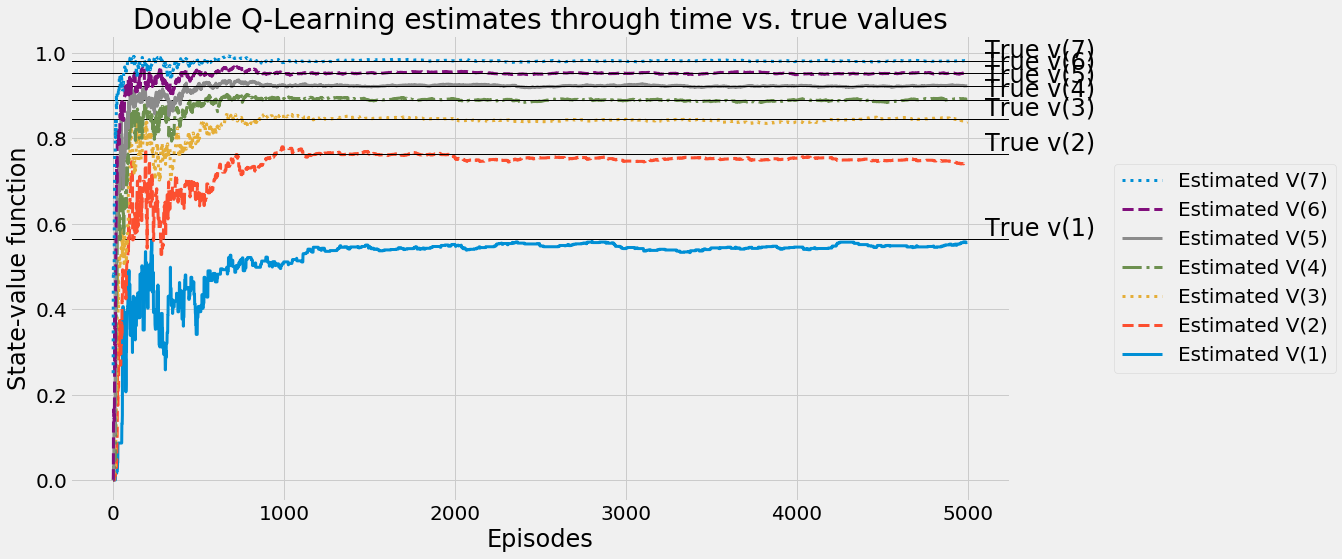

In [28]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    log=False)

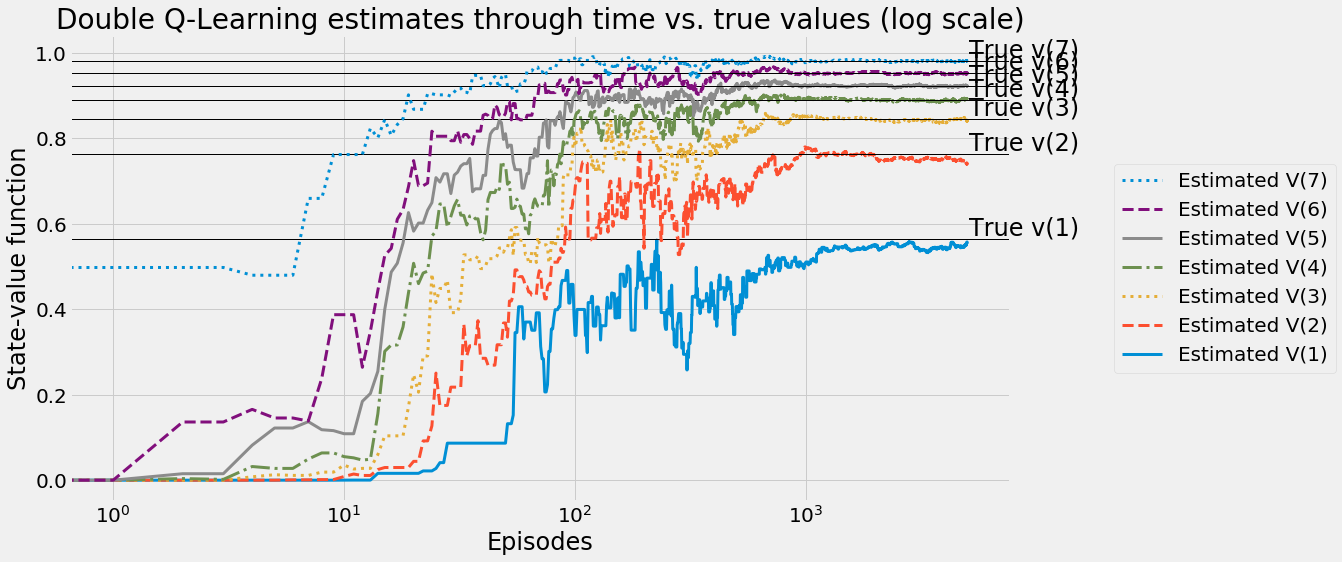

In [29]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_dql, axis=2), 
    optimal_V, 
    log=True)

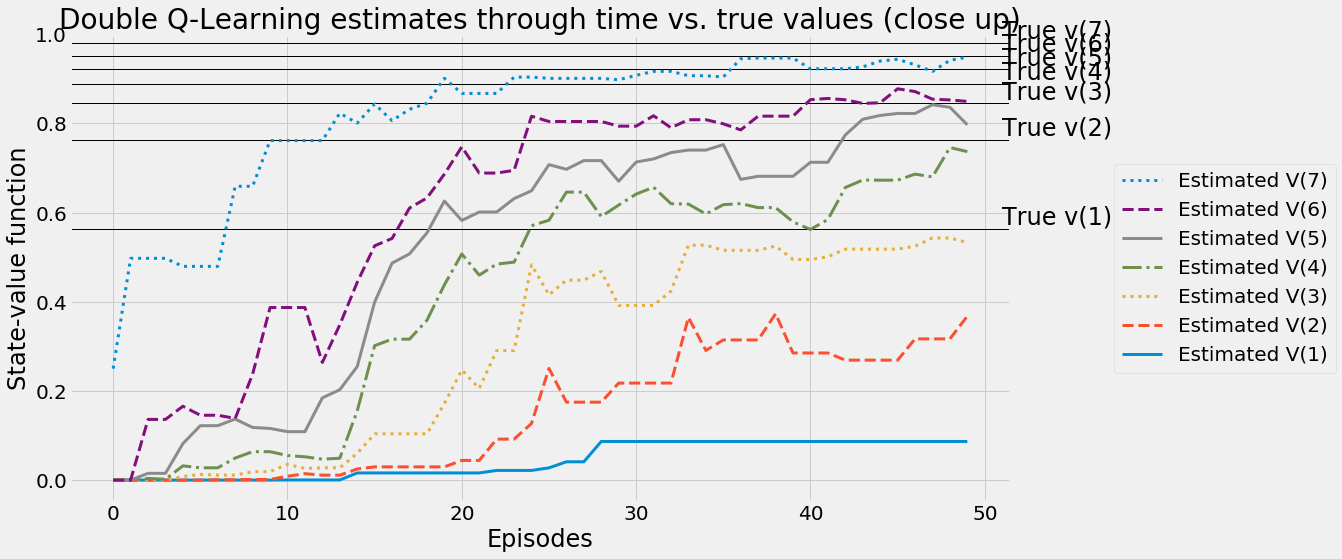

In [30]:
plot_value_function(
    'Double Q-Learning estimates through time vs. true values (close up)', 
    np.max(Q_track_dql, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## SARSA(λ)

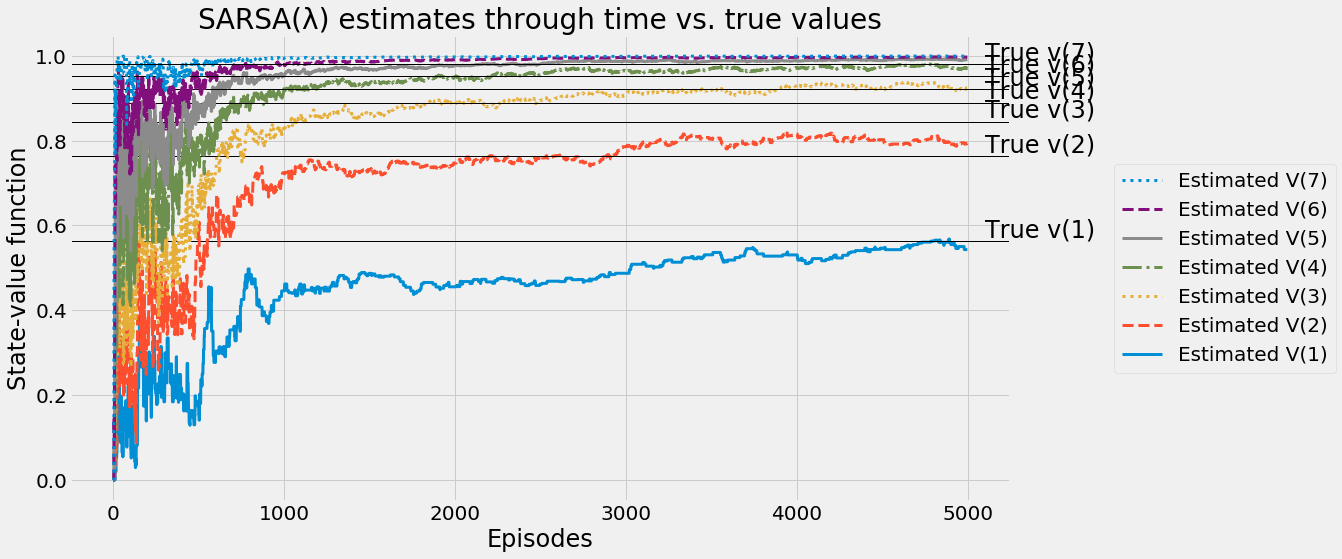

In [31]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    log=False)

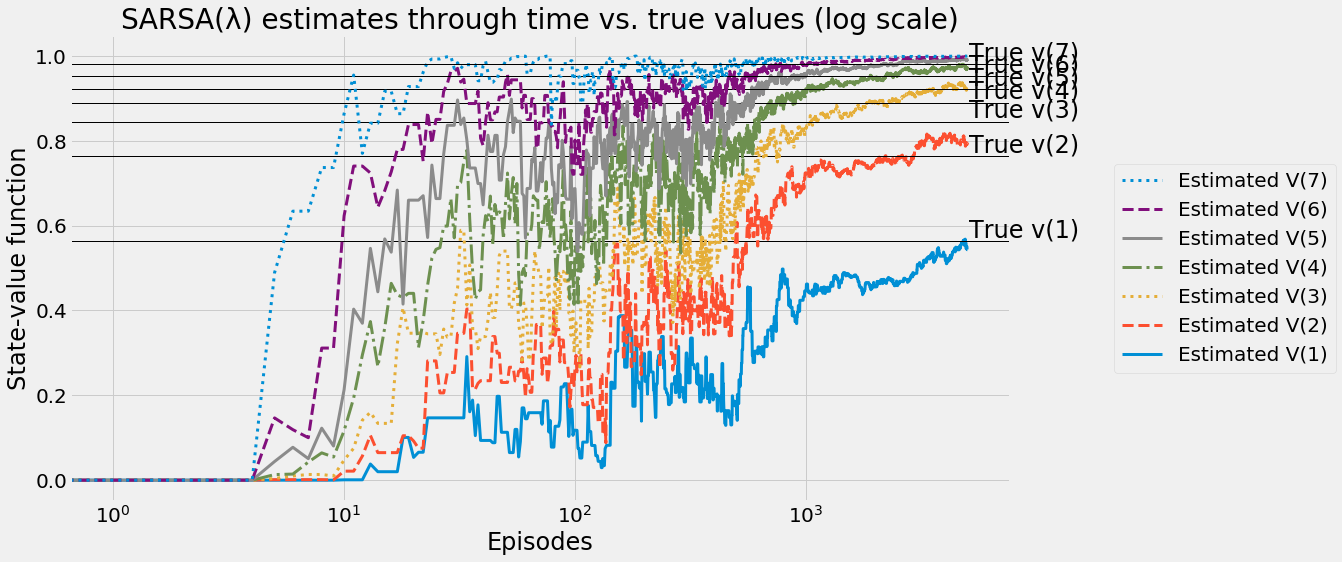

In [32]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_sl, axis=2), 
    optimal_V, 
    log=True)

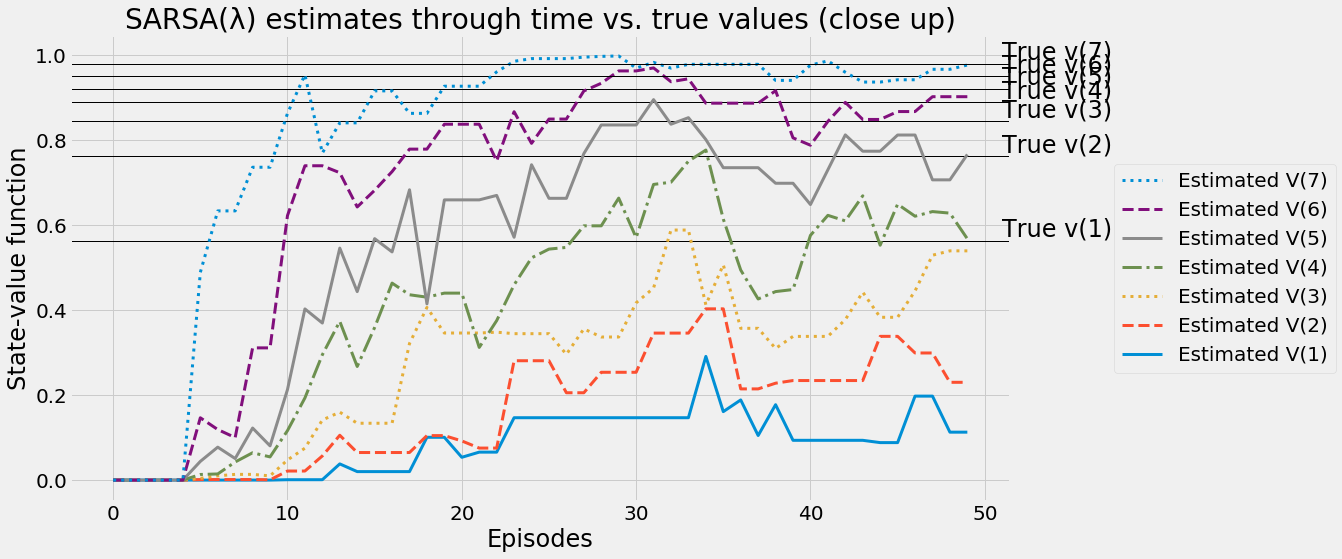

In [33]:
plot_value_function(
    'SARSA(λ) estimates through time vs. true values (close up)', 
    np.max(Q_track_sl, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## Q(λ)

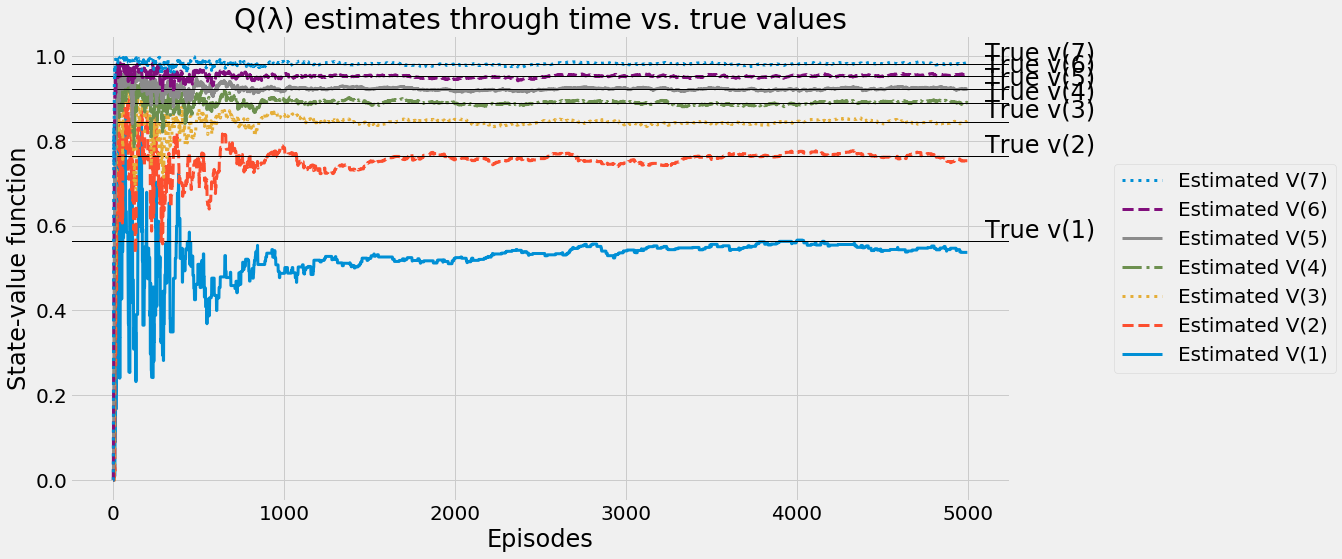

In [34]:
plot_value_function(
    'Q(λ) estimates through time vs. true values', 
    np.max(Q_track_qll, axis=2), 
    optimal_V,
    log=False)

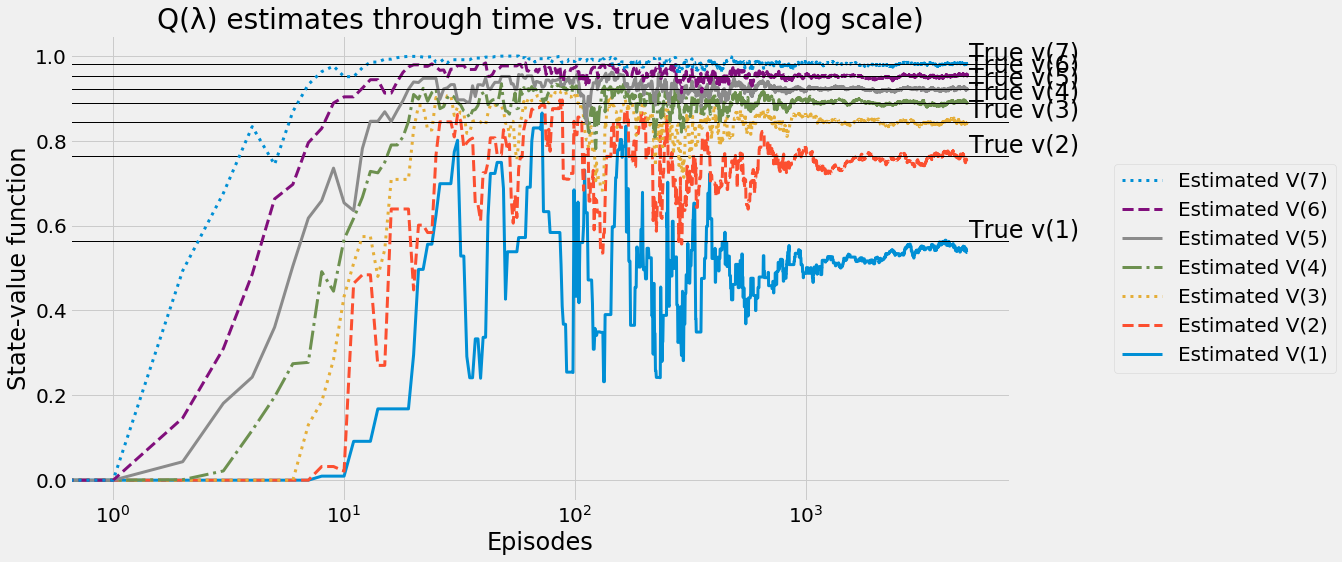

In [35]:
plot_value_function(
    'Q(λ) estimates through time vs. true values (log scale)', 
    np.max(Q_track_qll, axis=2), 
    optimal_V, 
    log=True)

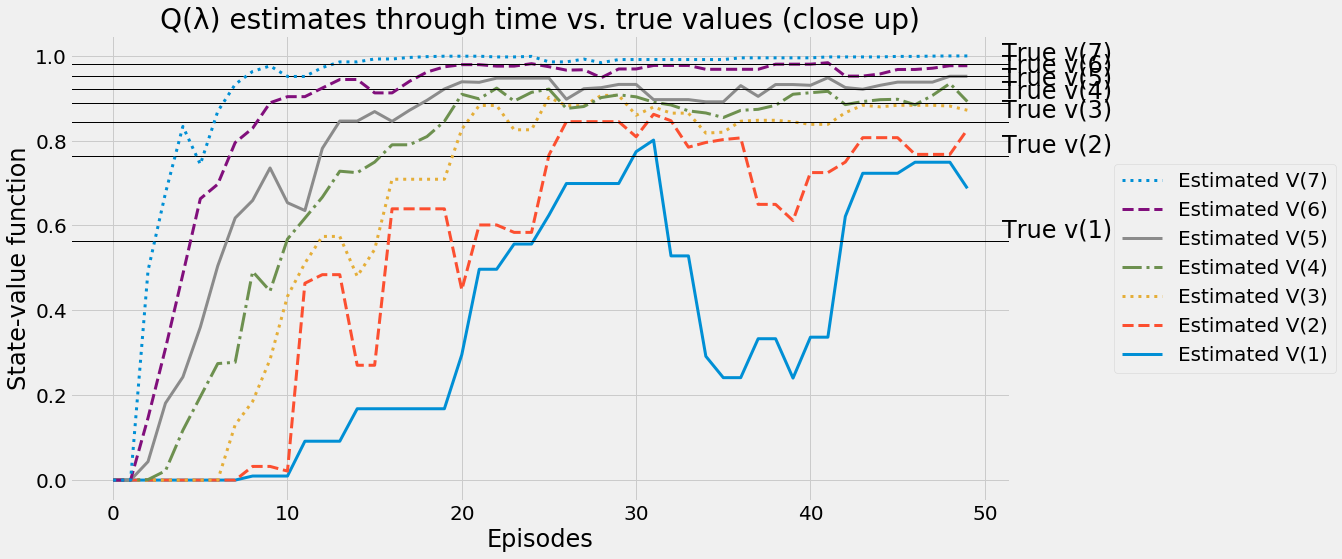

In [36]:
plot_value_function(
    'Q(λ) estimates through time vs. true values (close up)', 
    np.max(Q_track_qll, axis=2)[:50], 
    optimal_V[:50],
    log=False)

# Dyna-Q

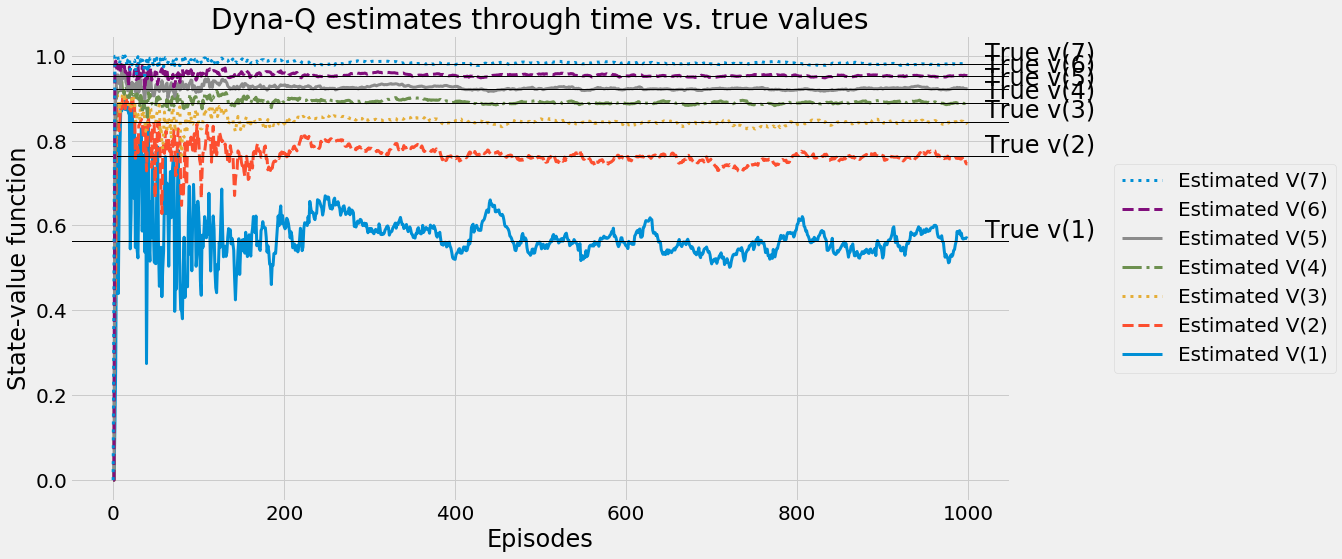

In [37]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    log=False)

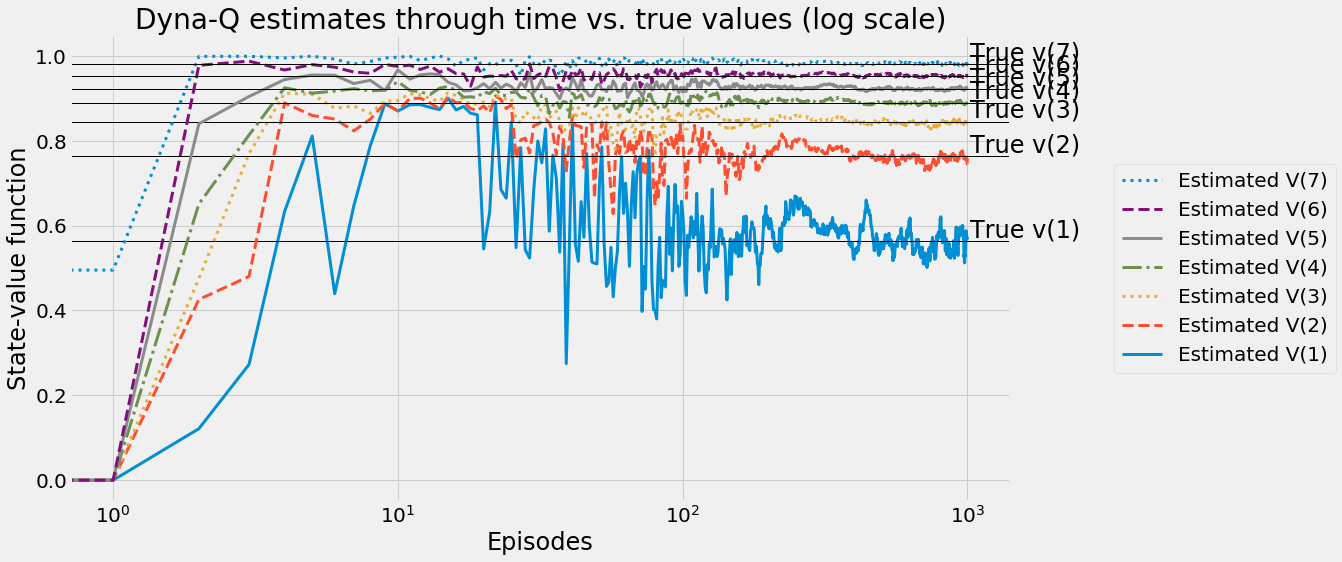

In [38]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (log scale)', 
    np.max(Q_track_dq, axis=2), 
    optimal_V, 
    log=True)

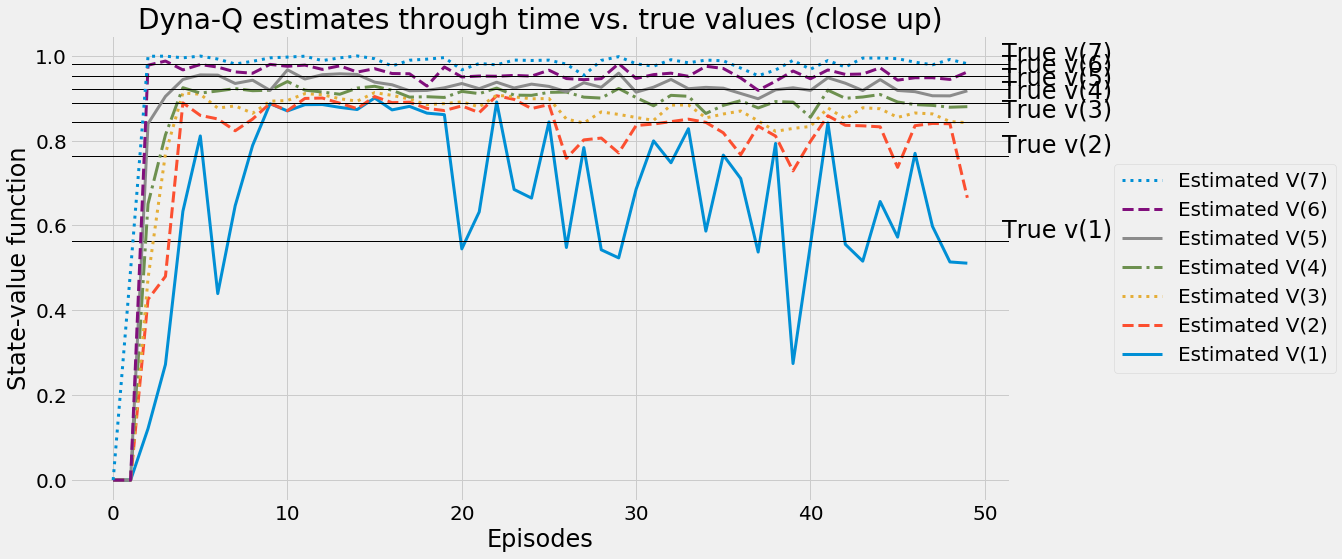

In [39]:
plot_value_function(
    'Dyna-Q estimates through time vs. true values (close up)', 
    np.max(Q_track_dq, axis=2)[:50], 
    optimal_V[:50],
    log=False)

# FrozenLake environment

In [40]:
env = gym.make('FrozenLake-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=15)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │
╞═════╪════════╪════════╪════════╪════════╡
│   0 │ 0.542  │ 0.5278 │ 0.5278 │ 0.5223 │
├─────┼────────┼────────┼────────┼────────┤
│   1 │ 0.3435 │ 0.3342 │ 0.3199 │ 0.4988 │
├─────┼────────┼────────┼────────┼────────┤
│   2 │ 0.4382 │ 0.4336 │ 0.4243 │ 0.4707 │
├─────┼────────┼────────┼────────┼────────┤
│   3 │ 0.3061 │ 0.3061 │ 0.3015 │ 0.4569 │
├─────┼────────┼────────┼────────┼────────┤
│   4 │ 0.5585 │ 0.3796 │ 0.3742 │ 0.3632 │
├─────┼────────┼────────┼────────┼────────┤
│   5 │ 0      │ 0      │ 0      │ 0      │
├─────┼────────┼────────┼────────┼────────┤
│   6 │ 0.3583 │ 0.203  │ 0.3583 │ 0.1553 │
├─────┼────────┼────────┼────────┼

In [41]:
Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=0.99, n_episodes=20000)

In [42]:
print_state_value_function(V_dql, P, n_cols=4, prec=3, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dql, goal_state=15)*100))

State-value function found by Double Q-Learning:
| 00  0.508 | 01  0.419 | 02  0.358 | 03  0.292 |
| 04  0.524 |           | 06    0.3 |           |
| 08  0.561 | 09  0.614 | 10   0.58 |           |
|           | 13   0.72 | 14  0.864 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.034 | 01  -0.08 | 02 -0.113 | 03 -0.164 |
| 04 -0.034 |           | 06 -0.059 |           |
| 08 -0.031 | 09 -0.029 | 10 -0.035 |           |
|           | 13 -0.022 | 14  0.001 |           |
State-value function RMSE: 0.0588

Double Q-Learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   

In [43]:
Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env, gamma=0.99, n_episodes=20000)

In [44]:
print_state_value_function(V_sl, P, n_cols=4, prec=3, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sl, goal_state=15)*100))

State-value function found by SARSA(λ):
| 00  0.301 | 01  0.252 | 02  0.213 | 03  0.164 |
| 04  0.319 |           | 06   0.21 |           |
| 08  0.363 | 09  0.445 | 10   0.44 |           |
|           | 13  0.585 | 14  0.776 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.241 | 01 -0.247 | 02 -0.258 | 03 -0.293 |
| 04  -0.24 |           | 06 -0.148 |           |
| 08 -0.229 | 09 -0.198 | 10 -0.175 |           |
|           | 13 -0.157 | 14 -0.087 |           |
State-value function RMSE: 0.1778

SARSA(λ) action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══

In [45]:
Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99, n_episodes=20000)

In [46]:
print_state_value_function(V_qll, P, n_cols=4, prec=3, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_qll, goal_state=15)*100))

State-value function found by Q(λ):
| 00  0.525 | 01  0.471 | 02  0.437 | 03   0.42 |
| 04  0.543 |           | 06  0.343 |           |
| 08  0.587 | 09  0.643 | 10  0.609 |           |
|           | 13  0.737 | 14  0.864 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.017 | 01 -0.028 | 02 -0.034 | 03 -0.037 |
| 04 -0.016 |           | 06 -0.016 |           |
| 08 -0.005 | 09    0.0 | 10 -0.006 |           |
|           | 13 -0.005 | 14  0.001 |           |
State-value function RMSE: 0.0161

Q(λ) action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══

In [47]:
Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99, n_episodes=10000)

In [48]:
print_state_value_function(V_dq, P, n_cols=4, prec=3, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dq, goal_state=15)*100))

State-value function found by Dyna-Q:
| 00  0.526 | 01  0.485 | 02  0.462 | 03   0.45 |
| 04  0.543 |           | 06  0.365 |           |
| 08  0.578 | 09  0.636 | 10  0.589 |           |
|           | 13  0.734 | 14  0.866 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.016 | 01 -0.014 | 02 -0.009 | 03 -0.007 |
| 04 -0.016 |           | 06  0.006 |           |
| 08 -0.014 | 09 -0.007 | 10 -0.026 |           |
|           | 13 -0.007 | 14  0.003 |           |
State-value function RMSE: 0.0107

Dyna-Q action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════

# Policy evolution comparison

In [49]:
dql_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_dql)])

In [50]:
sl_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_sl)])

In [51]:
qll_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_qll)])

In [52]:
dq_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_dq)])

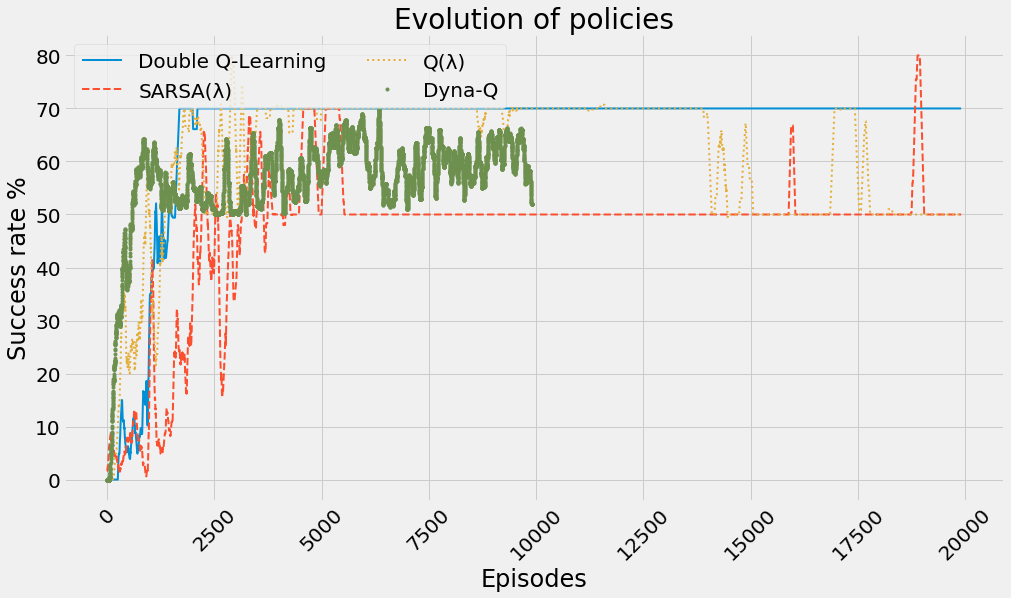

In [53]:
plt.plot(dql_success_evolution, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_success_evolution, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_success_evolution, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_success_evolution, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of policies')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.xticks(rotation=45)

plt.show()

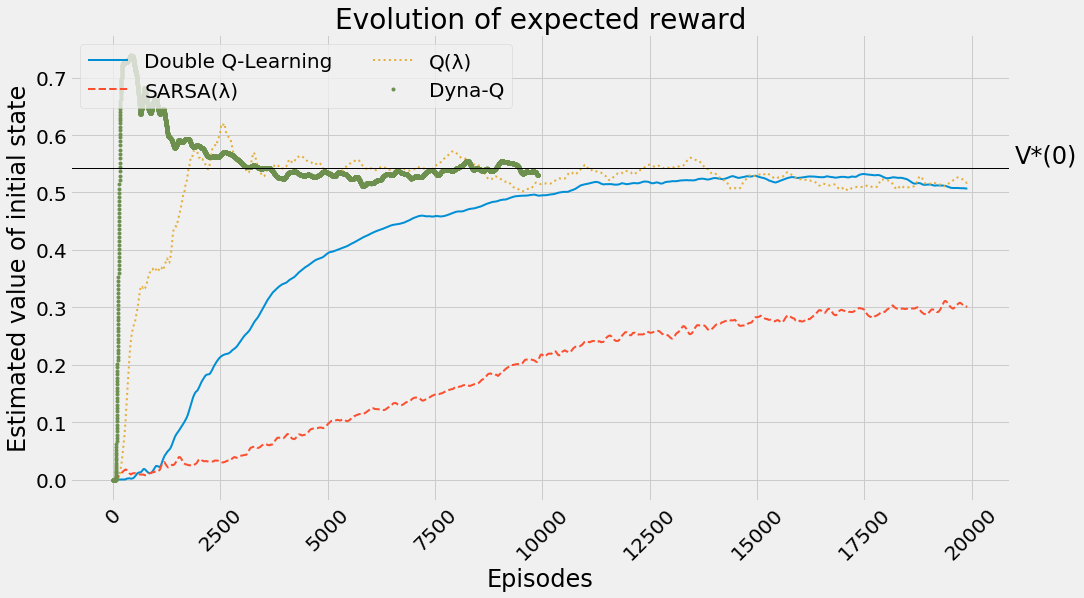

In [54]:
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[0]), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.max(Q_track_sl, axis=2).T[0]), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.max(Q_track_qll, axis=2).T[0]), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[0]), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.axhline(y=optimal_V[0], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_dql)*1.05), optimal_V[0]+.01, 'V*(0)')


plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

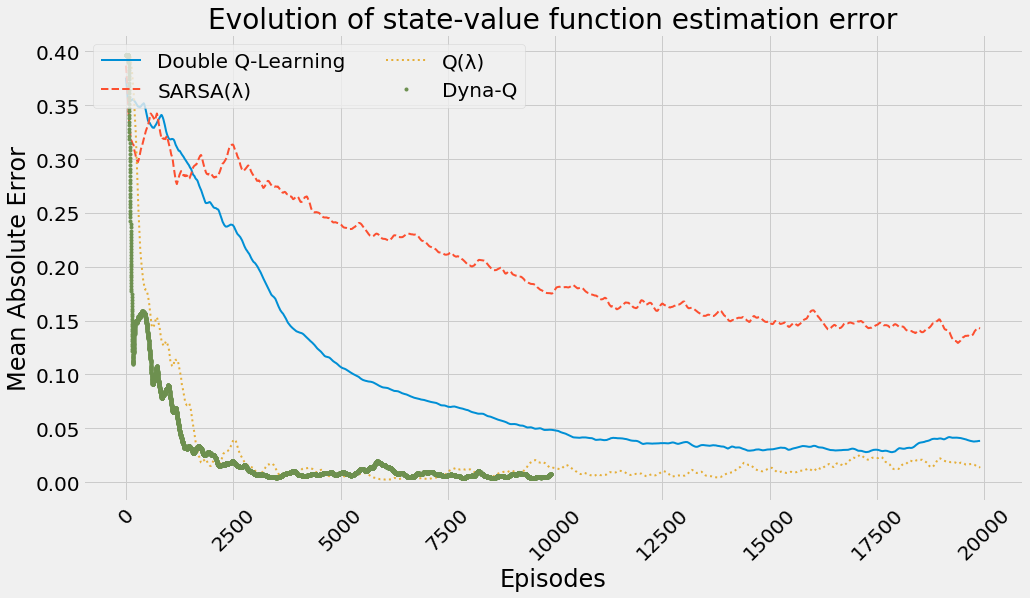

In [55]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sl, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_qll, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

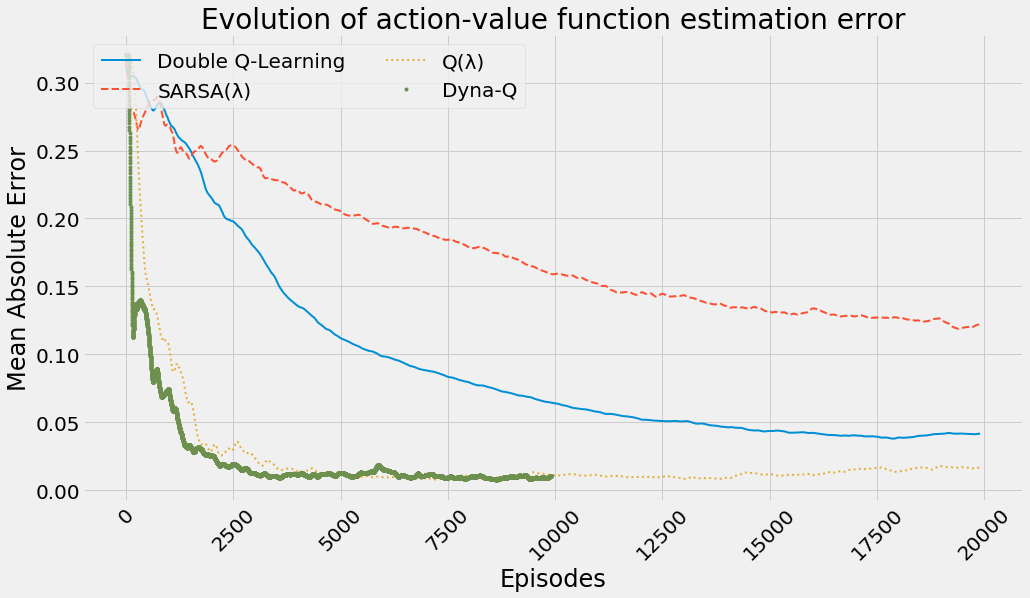

In [56]:
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_sl - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_qll - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

In [57]:
dql_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dql)])

In [58]:
sl_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_sl)])

In [59]:
qll_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_qll)])

In [60]:
dq_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dq)])

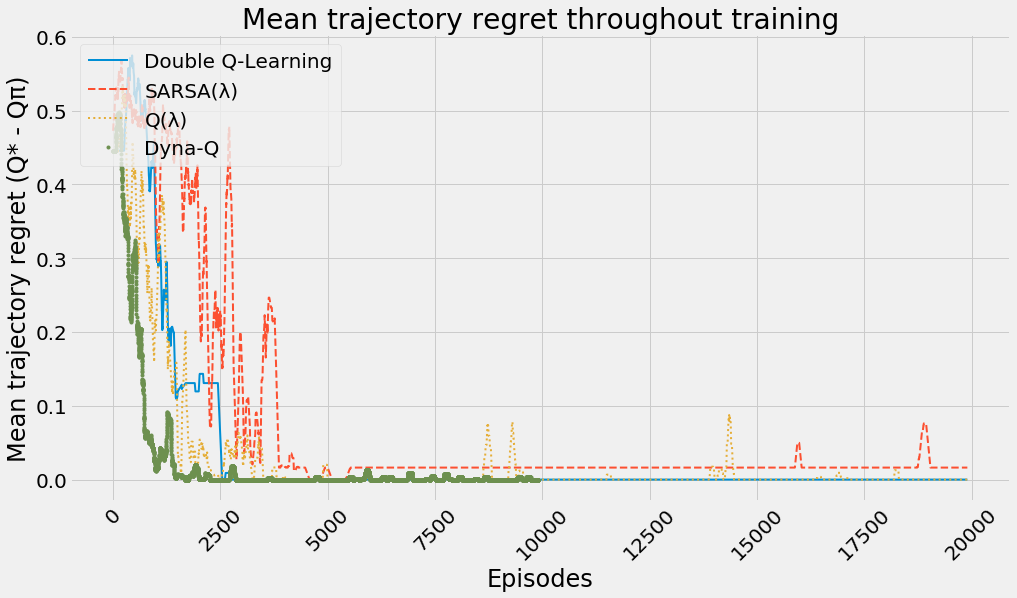

In [61]:
plt.plot(dql_regret_accumulation, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_regret_accumulation, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_regret_accumulation, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_regret_accumulation, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=1)

plt.title('Mean trajectory regret throughout training')
plt.xlabel('Episodes')
plt.ylabel('Mean trajectory regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

# FrozenLake XL (8x8)

In [62]:
env = gym.make('FrozenLake8x8-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=8, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=63)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00 0.4146 | 01 0.4272 | 02 0.4461 | 03 0.4683 | 04 0.4924 | 05 0.5166 | 06 0.5353 | 07  0.541 |
| 08 0.4117 | 09 0.4212 | 10 0.4375 | 11 0.4584 | 12 0.4832 | 13 0.5135 | 14 0.5458 | 15 0.5574 |
| 16 0.3968 | 17 0.3938 | 18 0.3755 |           | 20 0.4217 | 21 0.4938 | 22 0.5612 | 23 0.5859 |
| 24 0.3693 | 25  0.353 | 26 0.3065 | 27 0.2004 | 28 0.3008 |           | 30  0.569 | 31 0.6283 |
| 32 0.3327 | 33 0.2914 | 34 0.1973 |           | 36 0.2893 | 37  0.362 | 38 0.5348 | 39 0.6897 |
| 40 0.3061 |           |           | 43 0.0863 | 44 0.2139 | 45 0.2727 |           | 47  0.772 |
| 48 0.2889 |           | 50 0.0577 | 51 0.0475 |           | 53 0.2505 |           | 55 0.8778 |
| 56 0.2804 | 57 0.2008 | 58 0.1273 |           | 60 0.2396 | 61 0.4864 | 62 0.7371 |           |

Optimal action-value function:
╒═════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │
╞═════╪════════╪════════╪════════╪════════╡
│   0 │ 0.4095 │ 0.413

In [63]:
Q_dql, V_dql, pi_dql, Q_track_dql, pi_track_dql = double_q_learning(env, gamma=0.99, n_episodes=40000)

In [64]:
print_state_value_function(V_dql, P, n_cols=8, prec=3, title='State-value function found by Double Q-Learning:')
print_state_value_function(optimal_V, P, n_cols=8, prec=3, title='Optimal state-value function:')
print_state_value_function(V_dql - optimal_V, P, n_cols=8, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dql, optimal_V)))
print()
print_action_value_function(Q_dql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Double Q-Learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dql, optimal_Q)))
print()
print_policy(pi_dql, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dql, goal_state=63)*100))

State-value function found by Double Q-Learning:
| 00  0.381 | 01  0.393 | 02  0.411 | 03  0.431 | 04  0.454 | 05  0.474 | 06  0.492 | 07  0.497 |
| 08  0.376 | 09  0.386 | 10  0.403 | 11   0.42 | 12  0.444 | 13   0.47 | 14  0.503 | 15  0.517 |
| 16  0.356 | 17  0.353 | 18  0.332 |           | 20  0.373 | 21  0.447 | 22  0.519 | 23  0.551 |
| 24  0.326 | 25   0.31 | 26  0.264 | 27  0.159 | 28  0.228 |           | 30  0.524 | 31    0.6 |
| 32  0.128 | 33  0.104 | 34  0.097 |           | 36  0.171 | 37  0.267 | 38  0.477 | 39  0.664 |
| 40  0.032 |           |           | 43  0.038 | 44  0.113 | 45  0.156 |           | 47  0.756 |
| 48  0.004 |           | 50    0.0 | 51  0.008 |           | 53  0.107 |           | 55  0.866 |
| 56    0.0 | 57    0.0 | 58    0.0 |           | 60  0.043 | 61  0.176 | 62  0.478 |           |
Optimal state-value function:
| 00  0.415 | 01  0.427 | 02  0.446 | 03  0.468 | 04  0.492 | 05  0.517 | 06  0.535 | 07  0.541 |
| 08  0.412 | 09  0.421 | 10  0.437 | 1

Reaches goal 85.30%.


In [65]:
Q_sl, V_sl, pi_sl, Q_track_sl, pi_track_sl = sarsa_lambda(env, gamma=0.99, n_episodes=40000)

In [66]:
print_state_value_function(V_sl, P, n_cols=8, prec=3, title='State-value function found by SARSA(λ):')
print_state_value_function(optimal_V, P, n_cols=8, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sl - optimal_V, P, n_cols=8, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sl, optimal_V)))
print()
print_action_value_function(Q_sl, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sl, optimal_Q)))
print()
print_policy(pi_sl, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sl, goal_state=63)*100))

State-value function found by SARSA(λ):
| 00  0.243 | 01   0.25 | 02  0.264 | 03   0.28 | 04  0.304 | 05   0.33 | 06  0.346 | 07  0.351 |
| 08  0.239 | 09  0.245 | 10  0.257 | 11  0.275 | 12  0.292 | 13  0.322 | 14  0.351 | 15  0.361 |
| 16  0.214 | 17  0.214 | 18    0.2 |           | 20  0.221 | 21  0.295 | 22  0.358 | 23  0.379 |
| 24  0.151 | 25  0.154 | 26  0.138 | 27  0.095 | 28  0.136 |           | 30  0.361 | 31  0.417 |
| 32  0.038 | 33  0.039 | 34  0.031 |           | 36  0.126 | 37  0.169 | 38  0.335 | 39  0.484 |
| 40  0.003 |           |           | 43  0.032 | 44  0.077 | 45  0.084 |           | 47  0.582 |
| 48  0.001 |           | 50  0.002 | 51   0.01 |           | 53  0.032 |           | 55  0.751 |
| 56    0.0 | 57    0.0 | 58    0.0 |           | 60    0.0 | 61  0.042 | 62  0.126 |           |
Optimal state-value function:
| 00  0.415 | 01  0.427 | 02  0.446 | 03  0.468 | 04  0.492 | 05  0.517 | 06  0.535 | 07  0.541 |
| 08  0.412 | 09  0.421 | 10  0.437 | 11  0.458 

Reaches goal 85.50%.


In [67]:
Q_qll, V_qll, pi_qll, Q_track_qll, pi_track_qll = q_lambda(env, gamma=0.99, n_episodes=40000)

In [68]:
print_state_value_function(V_qll, P, n_cols=8, prec=3, title='State-value function found by Q(λ):')
print_state_value_function(optimal_V, P, n_cols=8, prec=3, title='Optimal state-value function:')
print_state_value_function(V_qll - optimal_V, P, n_cols=8, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_qll, optimal_V)))
print()
print_action_value_function(Q_qll, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q(λ) action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_qll, optimal_Q)))
print()
print_policy(pi_qll, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_qll, goal_state=63)*100))

State-value function found by Q(λ):
| 00  0.398 | 01  0.411 | 02  0.434 | 03  0.459 | 04  0.482 | 05  0.506 | 06  0.523 | 07  0.529 |
| 08  0.397 | 09  0.405 | 10  0.425 | 11  0.449 | 12  0.472 | 13  0.503 | 14  0.538 | 15  0.551 |
| 16  0.377 | 17  0.372 | 18   0.36 |           | 20  0.411 | 21  0.478 | 22  0.555 | 23  0.582 |
| 24   0.35 | 25  0.329 | 26  0.292 | 27  0.197 | 28   0.29 |           | 30  0.567 | 31  0.626 |
| 32  0.301 | 33  0.273 | 34  0.188 |           | 36  0.257 | 37  0.335 | 38  0.541 | 39  0.685 |
| 40  0.253 |           |           | 43  0.053 | 44  0.166 | 45  0.214 |           | 47  0.768 |
| 48  0.205 |           | 50  0.004 | 51   0.01 |           | 53   0.16 |           | 55  0.876 |
| 56  0.181 | 57  0.069 | 58  0.025 |           | 60  0.035 | 61  0.278 | 62  0.349 |           |
Optimal state-value function:
| 00  0.415 | 01  0.427 | 02  0.446 | 03  0.468 | 04  0.492 | 05  0.517 | 06  0.535 | 07  0.541 |
| 08  0.412 | 09  0.421 | 10  0.437 | 11  0.458 | 12

Reaches goal 84.40%.


In [69]:
Q_dq, V_dq, pi_dq, Q_track_dq, pi_track_dq = dyna_q(env, gamma=0.99, n_episodes=20000)

In [70]:
print_state_value_function(V_dq, P, n_cols=8, prec=3, title='State-value function found by Dyna-Q:')
print_state_value_function(optimal_V, P, n_cols=8, prec=3, title='Optimal state-value function:')
print_state_value_function(V_dq - optimal_V, P, n_cols=8, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_dq, optimal_V)))
print()
print_action_value_function(Q_dq, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Dyna-Q action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_dq, optimal_Q)))
print()
print_policy(pi_dq, P, action_symbols=('<', 'v', '>', '^'), n_cols=8)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_dq, goal_state=63)*100))

State-value function found by Dyna-Q:
| 00  0.408 | 01  0.422 | 02  0.443 | 03  0.466 | 04   0.49 | 05  0.515 | 06  0.534 | 07   0.54 |
| 08  0.406 | 09  0.417 | 10  0.433 | 11  0.454 | 12  0.478 | 13  0.512 | 14  0.545 | 15  0.557 |
| 16  0.393 | 17  0.391 | 18  0.381 |           | 20  0.413 | 21  0.487 | 22   0.56 | 23  0.587 |
| 24   0.37 | 25  0.358 | 26  0.315 | 27  0.209 | 28  0.299 |           | 30  0.563 | 31  0.622 |
| 32  0.333 | 33  0.289 | 34  0.199 |           | 36  0.288 | 37   0.36 | 38  0.534 | 39  0.679 |
| 40  0.304 |           |           | 43  0.087 | 44  0.223 | 45  0.294 |           | 47  0.766 |
| 48   0.28 |           | 50  0.068 | 51   0.06 |           | 53  0.306 |           | 55   0.89 |
| 56  0.271 | 57  0.228 | 58   0.15 |           | 60  0.292 | 61  0.551 | 62  0.773 |           |
Optimal state-value function:
| 00  0.415 | 01  0.427 | 02  0.446 | 03  0.468 | 04  0.492 | 05  0.517 | 06  0.535 | 07  0.541 |
| 08  0.412 | 09  0.421 | 10  0.437 | 11  0.458 | 

Reaches goal 87.20%.


# Policy evolution comparison

In [71]:
dql_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_dql)])

In [72]:
sl_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_sl)])

In [73]:
qll_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_qll)])

In [74]:
dq_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=63, iterations=10)*100 for pi in tqdm(pi_track_dq)])

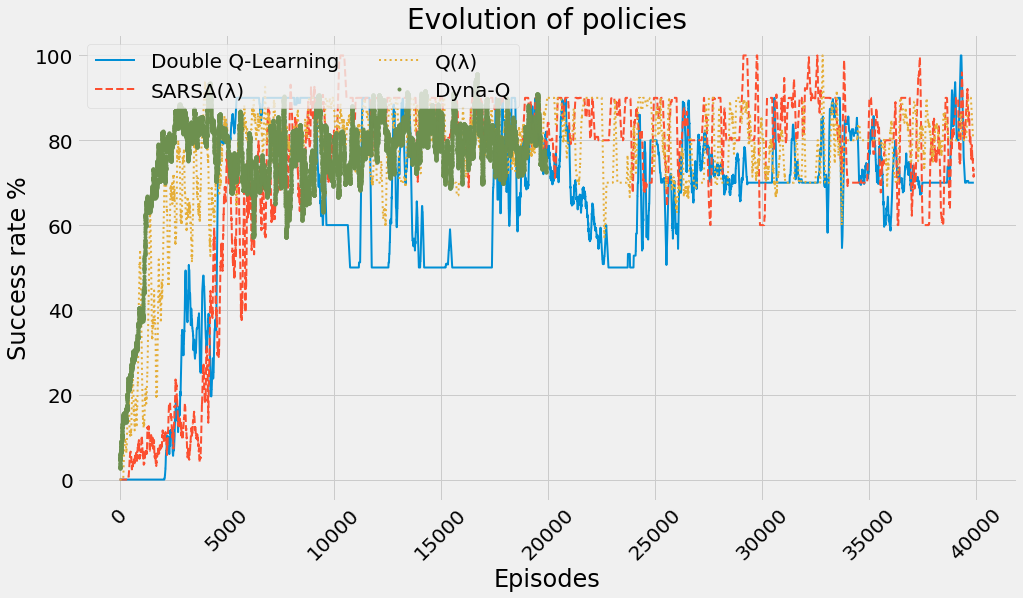

In [75]:
plt.plot(dql_success_evolution, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_success_evolution, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_success_evolution, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_success_evolution, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of policies')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.xticks(rotation=45)

plt.show()

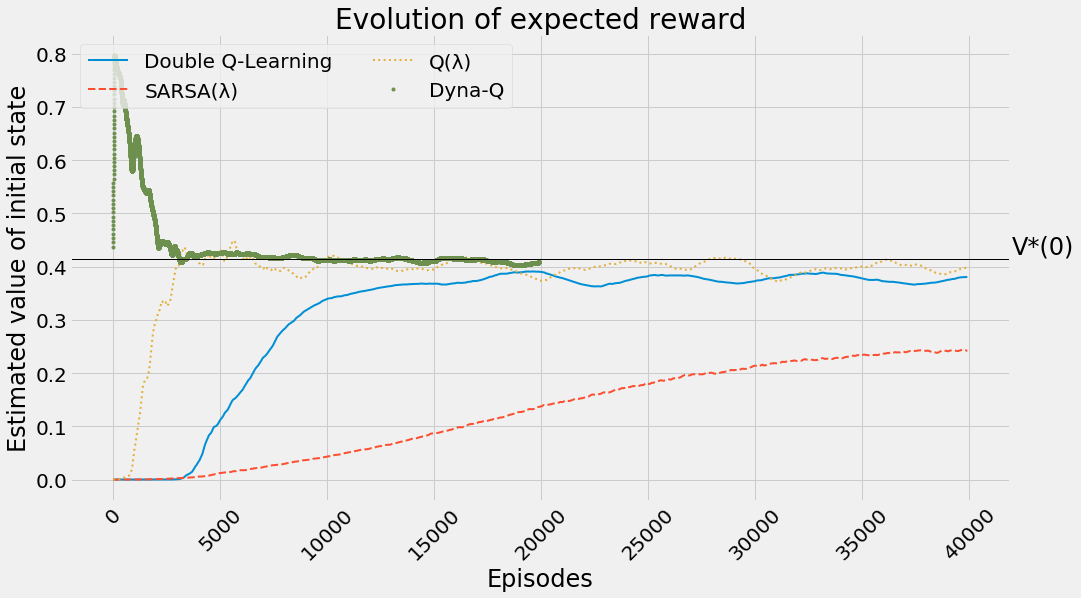

In [76]:
plt.plot(moving_average(np.max(Q_track_dql, axis=2).T[0]), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.max(Q_track_sl, axis=2).T[0]), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.max(Q_track_qll, axis=2).T[0]), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.max(Q_track_dq, axis=2).T[0]), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.axhline(y=optimal_V[0], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_dql)*1.05), optimal_V[0]+.01, 'V*(0)')


plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

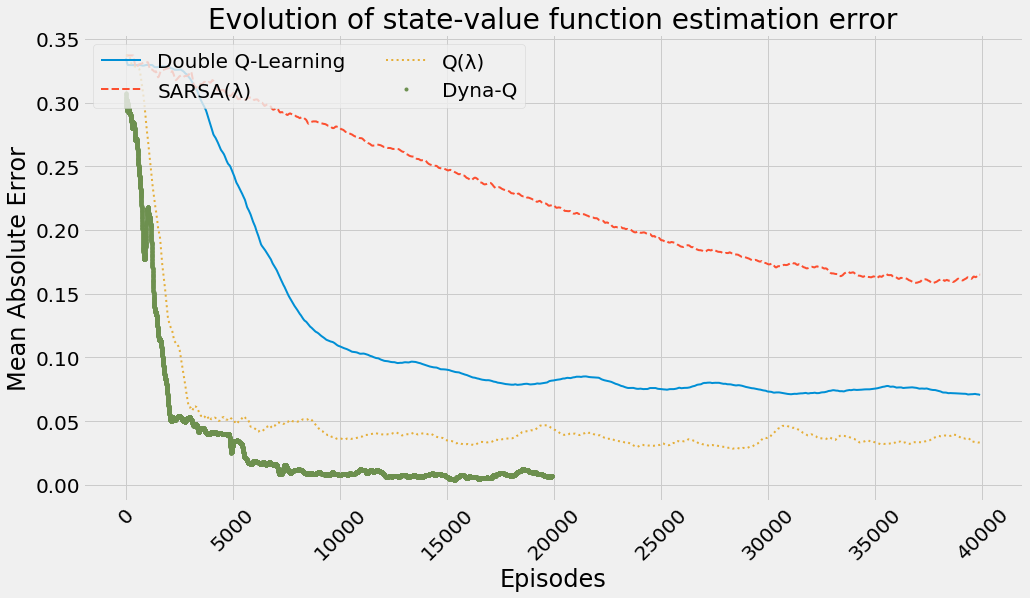

In [77]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dql, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sl, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_qll, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_dq, axis=2) - optimal_V), axis=1)), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

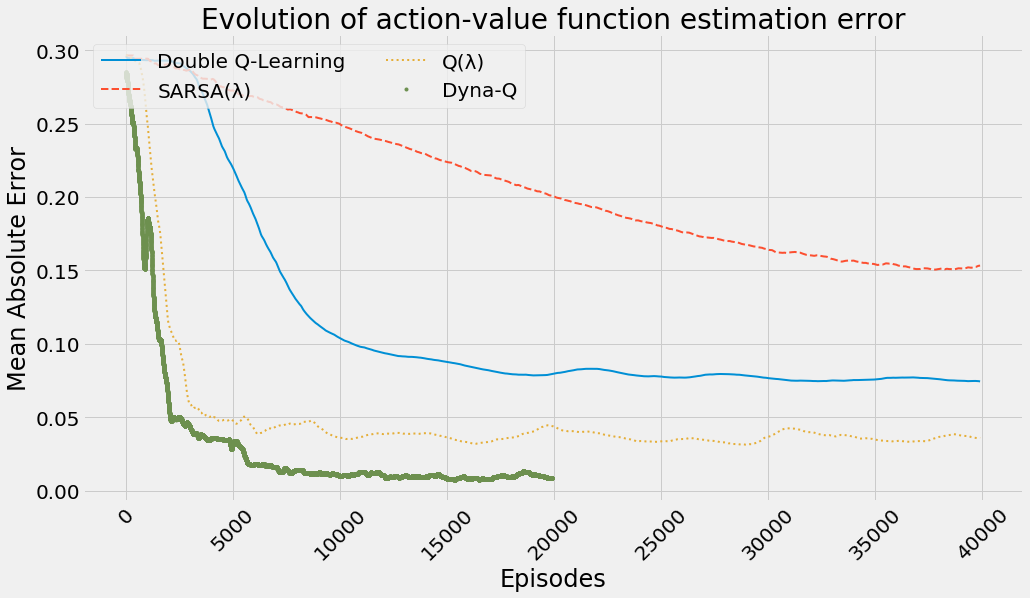

In [78]:
plt.plot(moving_average(np.mean(np.abs(Q_track_dql - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='Double Q-Learning')
plt.plot(moving_average(np.mean(np.abs(Q_track_sl - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_qll - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q(λ)')
plt.plot(moving_average(np.mean(np.abs(Q_track_dq - optimal_Q), axis=(1,2))), 
         '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=2)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

In [79]:
dql_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dql)])

In [80]:
sl_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_sl)])

In [81]:
qll_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_qll)])

In [82]:
dq_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_dq)])

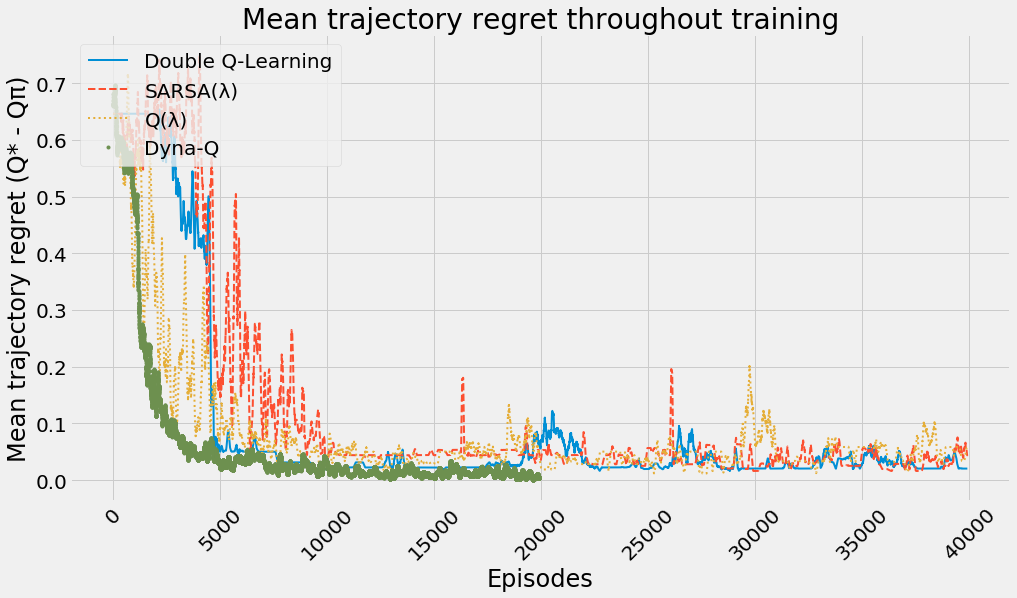

In [83]:
plt.plot(dql_regret_accumulation, '-', linewidth=2, label='Double Q-Learning')
plt.plot(sl_regret_accumulation, '--', linewidth=2, label='SARSA(λ)')
plt.plot(qll_regret_accumulation, ':', linewidth=2, label='Q(λ)')
plt.plot(dq_regret_accumulation, '.', linewidth=2, label='Dyna-Q')
plt.legend(loc=2, ncol=1)

plt.title('Mean trajectory regret throughout training')
plt.xlabel('Episodes')
plt.ylabel('Mean trajectory regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()